<a href="https://colab.research.google.com/github/shadeq2022/Belajar-Pengembangan-Machine-Learning/blob/main/Time%20Series/2.%20Submission_2_ML_Model_Data_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Membuat Model Machine Learning dengan Data Time Series**

Nama    : Muhammad Shadeq <br />
Dataset : https://www.kaggle.com/datasets/ananthr1/weather-prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout

In [2]:
df = pd.read_csv('seattle-weather.csv')
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [4]:
df = df[["date","temp_max"]]

In [7]:
df["date"] = pd.to_datetime(df["date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1461 non-null   datetime64[ns]
 1   temp_max  1461 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.0 KB


Text(0, 0.5, 'Temperature max')

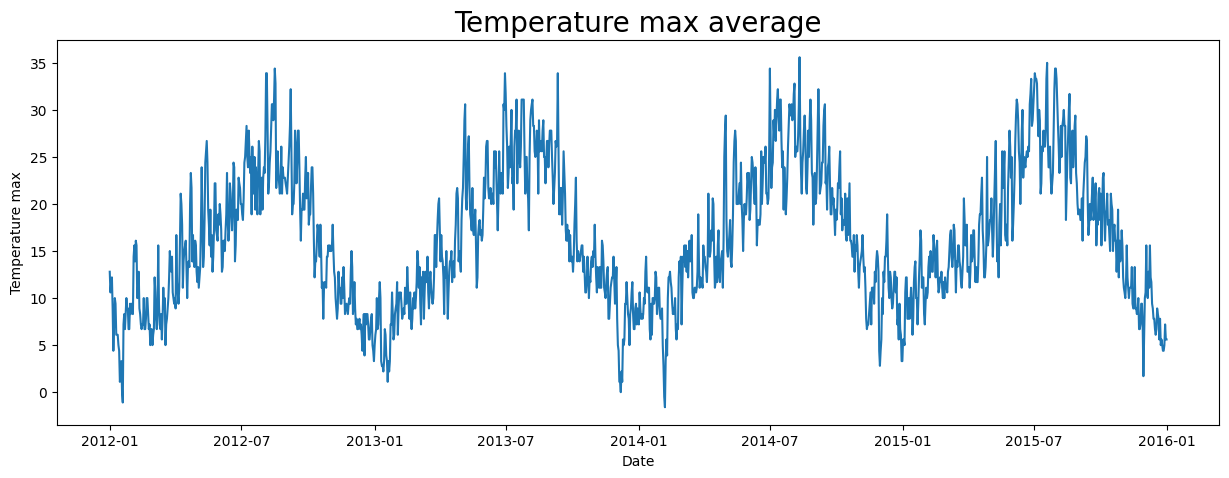

In [10]:
dates = df['date'].values
temp = df['temp_max'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature max average',
          fontsize=20);
plt.xlabel('Date')
plt.ylabel('Temperature max')

## **Splitting Data**

In [12]:
x_train, x_test, y_train, y_test = train_test_split(temp, dates, test_size = 0.2, random_state = 0 , shuffle=False)

In [13]:
#Total data train (80%) dan validation (20%)
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_test))

Total Data Train :  1168
Total Data Validation :  293


## **Pemodelan Sequential**

In [14]:
#Merubah data untuk dapat diterima model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [15]:
#Pemodelan Sequential

data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = Sequential([
    LSTM(64, return_sequences = True, input_shape=(100, 1)),
    Dropout(0.1),
    LSTM(64, return_sequences = True),
    Dropout(0.1),
    Bidirectional(LSTM(64)),
    Dropout(0.1),
    Dense(8, activation = 'relu'),
    Dense(1)
])

In [17]:
#10% MAE

x = (df['temp_max'].max() - df['temp_max'].min()) * 10/100
print(x)

3.72


In [18]:
#Callback jika <10% MAE

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<x and logs.get('val_mae')<x):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [21]:
#Implementasi Learning rate SGD pada optimizer
tf.keras.backend.set_floatx('float64')
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(data_x_train ,epochs=20, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/20
12/12 [==============================] - 14s 533ms/step - loss: 5.2539 - mae: 5.7344 - val_loss: 7.2416 - val_mae: 7.7332
Epoch 2/20
12/12 [==============================] - 7s 611ms/step - loss: 5.2526 - mae: 5.7351 - val_loss: 7.1750 - val_mae: 7.6651
Epoch 3/20
12/12 [==============================] - 4s 285ms/step - loss: 5.1544 - mae: 5.6350 - val_loss: 7.1323 - val_mae: 7.6225
Epoch 4/20
12/12 [==============================] - 5s 377ms/step - loss: 5.1447 - mae: 5.6240 - val_loss: 7.0766 - val_mae: 7.5668
Epoch 5/20
12/12 [==============================] - 4s 288ms/step - loss: 5.1190 - mae: 5.5966 - val_loss: 6.9876 - val_mae: 7.4778
Epoch 6/20
12/12 [==============================] - 4s 353ms/step - loss: 5.0118 - mae: 5.4934 - val_loss: 6.8897 - val_mae: 7.3791
Epoch 7/20
12/12 [==============================] - 4s 286ms/step - loss: 4.9510 - mae: 5.4273 - val_loss: 6.7700 - val_mae: 7.2575
Epoch 8/20
12/12 [==============================] - 4s 287ms/step - loss: 4

## **Grafik**

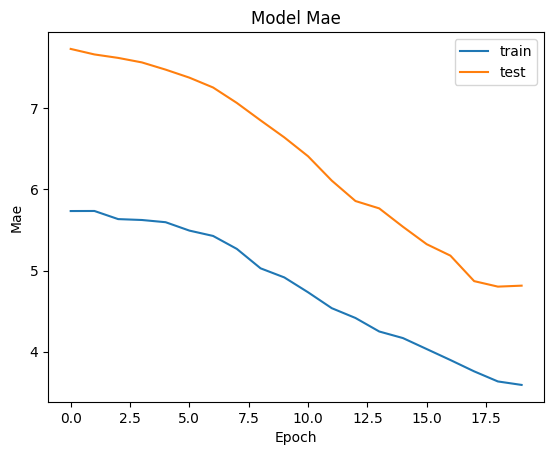

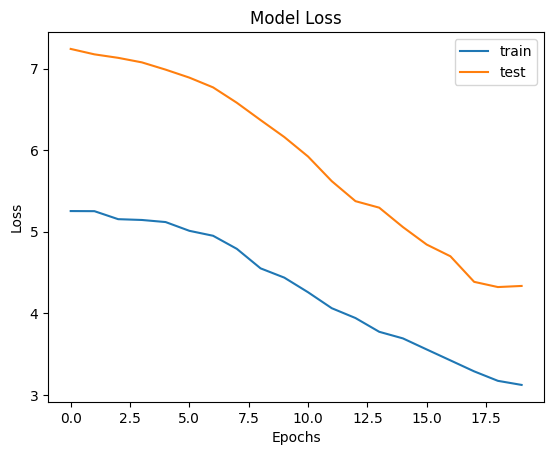

In [22]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()